# Scaling Python with Azure ML and Dask

![Describe gif](media/describe3.gif)

## Environment setup

In [1]:
pip install --upgrade azureml-sdk[notebooks] azureml-dataprep[fuse] fastparquet pyarrow dask distributed lz4

     |████████████████████████████████| 26.9MB 4.9MB/s eta 0:00:01
     |████████████████████████████████| 153kB 59.9MB/s eta 0:00:01
     |████████████████████████████████| 59.2MB 14.1MB/s eta 0:00:01
     |████████████████████████████████| 778kB 52.1MB/s eta 0:00:01
     |████████████████████████████████| 583kB 54.1MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 43.5MB/s eta 0:00:01
     |████████████████████████████████| 112kB 63.1MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 48.8MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 55.5MB/s eta 0:00:01
     |████████████████████████████████| 13.9MB 9.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 35.8MB/s eta 0:00:01
     |████████████████████████████████| 8.6MB 24.5MB/s eta 0:00:01
     |████████████████████████████████| 51kB 33.5MB/s eta 0:00:01
     |████████████████████████████████| 276kB 42.4MB/s eta 0:00:01
     |████████████████████████████████| 460kB 47.5MB/s eta 0:0

In [2]:
pip uninstall azureml-samples -y

Uninstalling azureml-samples-0+unknown:
  Successfully uninstalled azureml-samples-0+unknown
Note: you may need to restart the kernel to use updated packages.


In [3]:
# restart kernel
from IPython.core.display import HTML
HTML('<script>Jupyter.notebook.kernel.restart()</script>')

## Imports

In [4]:
import dask, os, sys, glob, socket
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

from azureml.core import Workspace, Experiment, Dataset, Environment
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.widgets import RunDetails
from azureml.core.runconfig import MpiConfiguration
from azureml.train.estimator import Estimator
from azureml.core.compute import ComputeTarget, AmlCompute
from IPython.core.display import HTML

import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline 

## Azure ML Setup

In [6]:
ws = Workspace.from_config()
ws

Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')

In [7]:
env_name = 'dasky'

if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

Exporting conda specifications for existing conda environment: azureml_py36


('dasky', '1')

In [8]:
dataset_name = 'weather-files'
data_paths   = ['https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet']

if dataset_name not in ws.datasets:
    ds = Dataset.File.from_files(data_paths, validate=False)
    ds = ds.register(ws, dataset_name)
else:
    ds = ws.datasets[dataset_name]
    
ds

{
  "source": [
    "https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet"
  ],
  "definition": [
    "GetFiles"
  ],
  "registration": {
    "id": "132f84ee-4f89-45f7-b2ca-fe22fe332295",
    "name": "weather-files",
    "version": 1,
    "workspace": "Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

In [9]:
pool_name = 'dask-cluster'

if pool_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                 = 'STANDARD_DS13_V2',
             max_nodes               = 100,
             vnet_resourcegroup_name = ws.resource_group,
             vnet_name               = 'dask-vnet',
             subnet_name             = 'default'
    )
    
    ct = ComputeTarget.create(ws, pool_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[pool_name]
    
ct

AmlCompute(workspace=Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg'), name=dask-cluster, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copetersrg/providers/Microsoft.MachineLearningServices/workspaces/bigdata/computes/dask-cluster, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Local Dask Client setup

In [10]:
dashboard_port = 9777

c = Client(dashboard_address=f':{dashboard_port}')
c.restart()

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker




<Client: 'tcp://127.0.0.1:44313' processes=6 threads=24, memory=236.64 GB>


## Download dataset and explore it 

In [11]:
data_path = '/mnt/noaa'
os.system('sudo chmod 777 /mnt') # stupid 

0

In [12]:
ds.download(data_path)

array(['/mnt/noaa/year=2008/month=1/part-00005-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-6.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=10/part-00001-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-2.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=11/part-00006-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-7.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=12/part-00000-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-1.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=2/part-00011-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-12.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=3/part-00003-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-4.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=4/part-00008-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-9.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=5/part-00002-tid-7339844144521752319-f

In [13]:
files = dask.delayed(glob.glob)(f'{data_path}/year=*/month=*/*.parquet', recursive=True).compute()
len(files)

144

In [14]:
files = dask.delayed(glob.glob)(f'{data_path}/year=2019/month=*/*.parquet', recursive=True).compute()
len(files)

12

In [15]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,062350,99999,2019-12-01 00:00:00,52.933,4.783,2.0,70.0,1.0,-0.5,1023.0,...,NaN,6.0,0.0,NaN,DE KOOIJ,NL,062350-99999,2019,1,1.0
1,062350,99999,2019-12-01 00:05:00,52.923,4.781,1.0,70.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,DE KOOIJ,NL,062350-99999,2019,1,1.0
2,062350,99999,2019-12-01 00:09:00,52.923,4.781,1.0,60.0,1.5,0.0,NaN,...,NaN,NaN,NaN,NaN,DE KOOIJ,NL,062350-99999,2019,1,1.0
3,062350,99999,2019-12-01 00:25:00,52.923,4.781,1.0,50.0,1.5,-1.0,NaN,...,NaN,NaN,NaN,NaN,DE KOOIJ,NL,062350-99999,2019,1,1.0
4,062350,99999,2019-12-01 00:27:00,52.923,4.781,1.0,50.0,1.0,-1.0,NaN,...,NaN,NaN,NaN,NaN,DE KOOIJ,NL,062350-99999,2019,1,1.0


In [16]:
%time len(df)

CPU times: user 450 ms, sys: 81.9 ms, total: 532 ms
Wall time: 5.31 s


124956666

In [17]:
%time df.describe().compute()

CPU times: user 5.63 s, sys: 688 ms, total: 6.32 s
Wall time: 34 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.249567e+08,1.249567e+08,1.249567e+08,1.066881e+08,1.105223e+08,1.222281e+08,5.175650e+07,1.298102e+07,4.331517e+06,3.038590e+07,3.038590e+07,1.033798e+06,124956666.0,1.249567e+08,124956666.0
mean,3.605756e+01,-3.450950e+01,3.812591e+02,1.661066e+02,3.398631e+00,1.246802e+01,1.014604e+03,3.558280e+01,4.214374e+00,1.607452e+01,2.462784e+03,1.392134e+01,2019.0,1.550841e+01,1.0
std,2.368553e+01,7.841385e+01,6.997652e+02,1.140600e+02,2.818132e+00,1.257927e+01,9.117536e+00,3.022886e+01,3.022310e+00,3.064271e+01,4.298749e+03,2.493581e+01,0.0,8.755722e+00,0.0
min,-9.000000e+01,-1.799830e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.614000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019.0,1.000000e+00,1.0
25%,3.283500e+01,-9.120000e+01,3.700000e+01,7.000000e+01,1.500000e+00,7.000000e+00,1.011000e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2019.0,8.000000e+00,1.0
50%,4.170600e+01,-4.545400e+01,1.810000e+02,1.900000e+02,3.100000e+00,1.590000e+01,1.017300e+03,6.000000e+01,5.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,2019.0,1.600000e+01,1.0
75%,4.922000e+01,2.136700e+01,4.350000e+02,2.800000e+02,5.100000e+00,2.700000e+01,1.024600e+03,7.100000e+01,8.000000e+00,2.400000e+01,9.999000e+03,5.100000e+01,2019.0,2.400000e+01,1.0
max,8.365600e+01,1.797500e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.150000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,7.000000e+02,2019.0,3.100000e+01,1.0


In [18]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 4.15 s, sys: 454 ms, total: 4.6 s
Wall time: 1min 25s
Dataframe is: 59.99GB


In [19]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute()
means.head()

CPU times: user 1.12 s, sys: 146 ms, total: 1.27 s
Wall time: 12 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-12-01,35.686406,-28.228631,360.279009,175.478089,3.981853,5.855555,1013.548670,44.089766,4.049514,15.576153,2237.343285,10.264063,2019.0,1.0,1.0
2019-12-02,35.524872,-26.631495,355.031343,193.481755,3.729187,5.131964,1013.759784,41.709580,4.231822,15.832952,2344.925119,10.387519,2019.0,2.0,1.0
2019-12-03,35.485145,-26.304343,356.857961,183.229631,3.412932,5.284842,1013.719291,36.478101,3.939732,16.800916,2509.195679,10.471727,2019.0,3.0,1.0
2019-12-04,35.678084,-26.293551,359.822438,179.825158,3.345195,5.907510,1012.489230,35.251974,3.690280,17.079001,2592.681675,8.721561,2019.0,4.0,1.0
2019-12-05,35.765118,-26.842292,365.346560,170.223266,3.381196,5.905347,1013.816391,34.091815,3.421430,15.732757,2460.998874,9.972270,2019.0,5.0,1.0


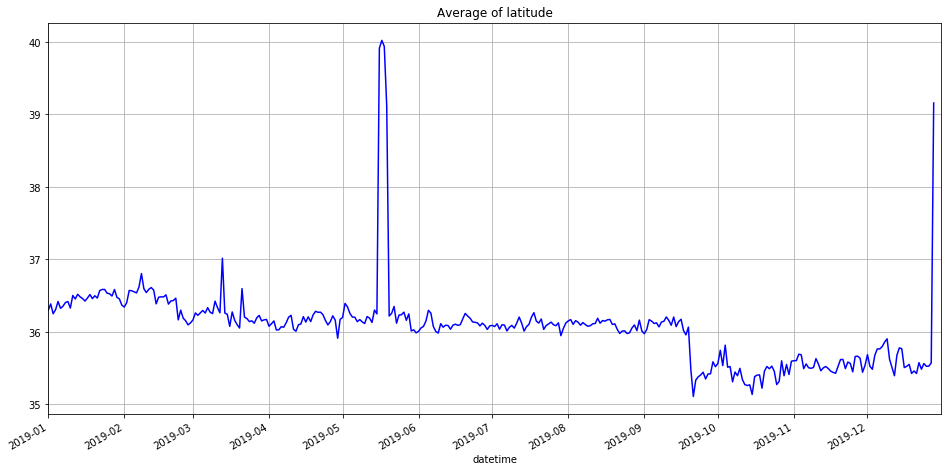

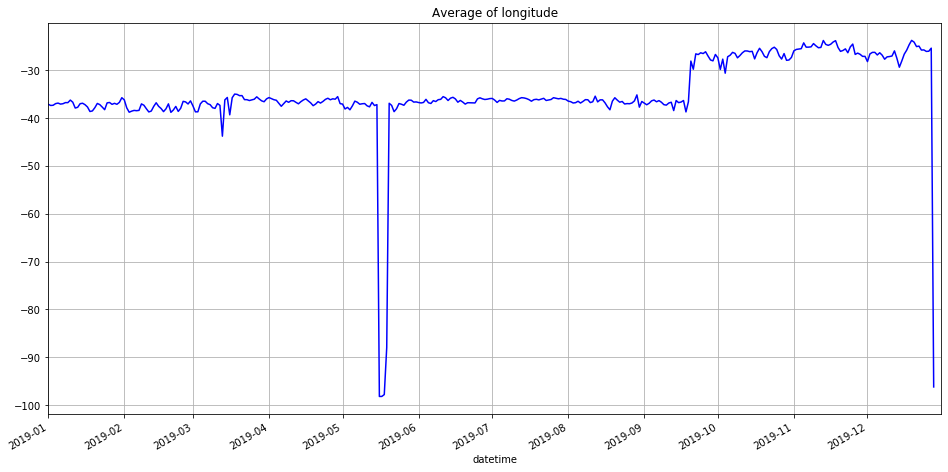

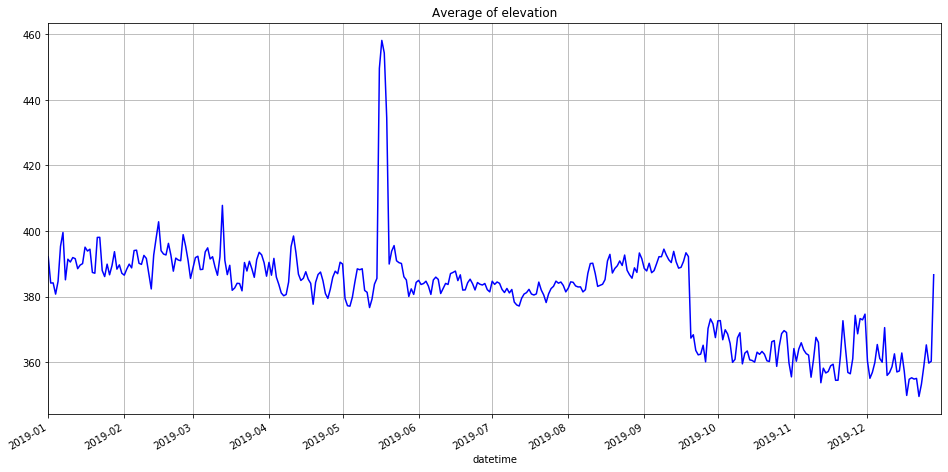

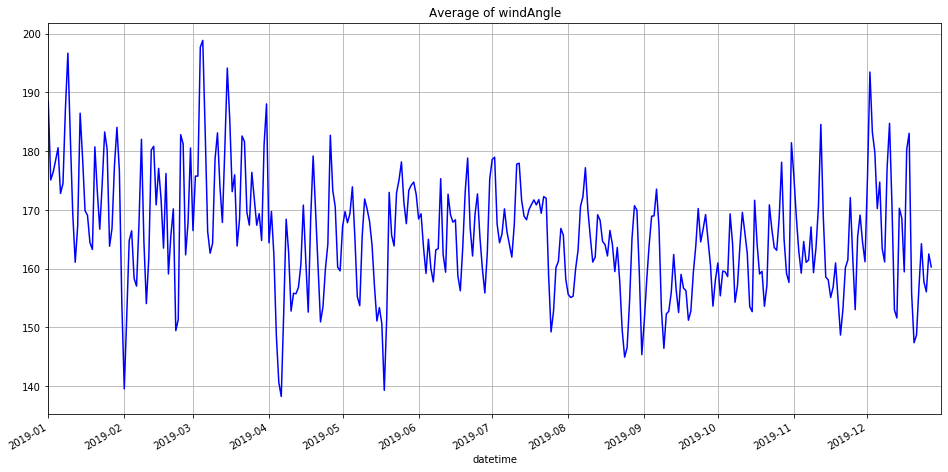

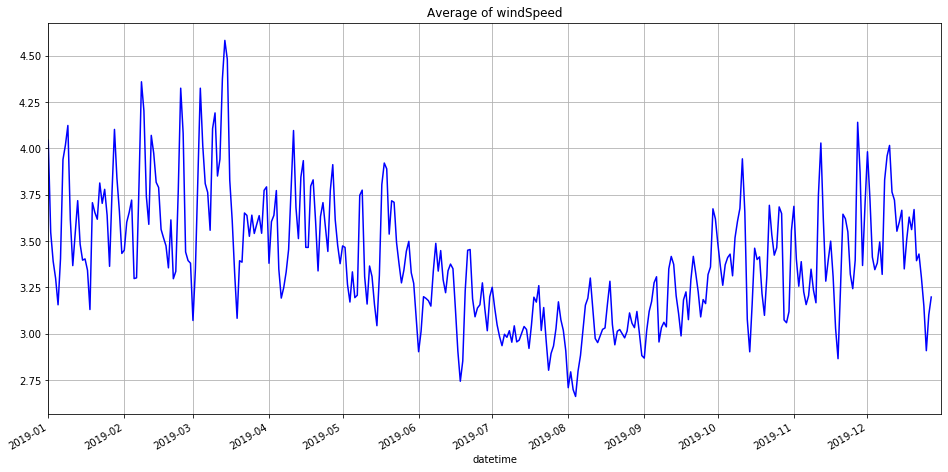

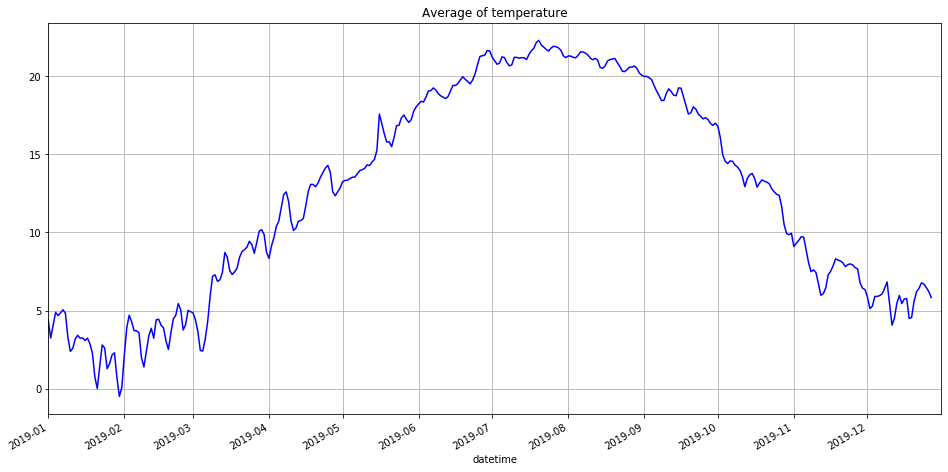

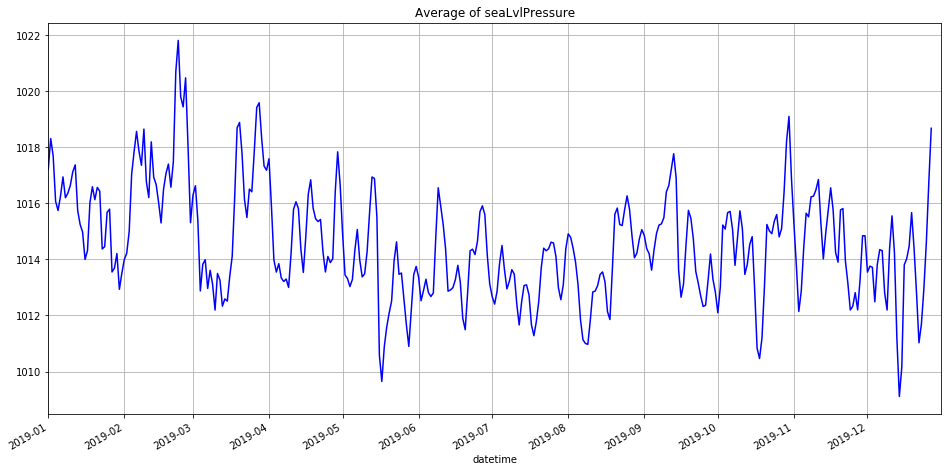

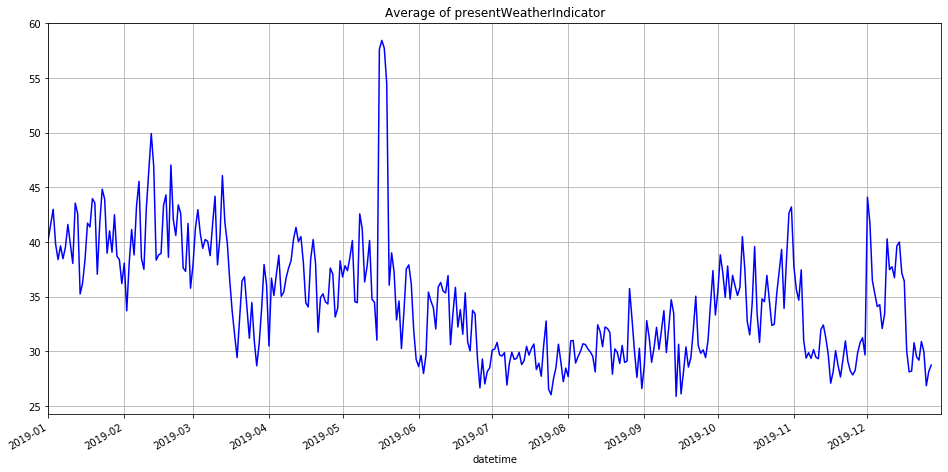

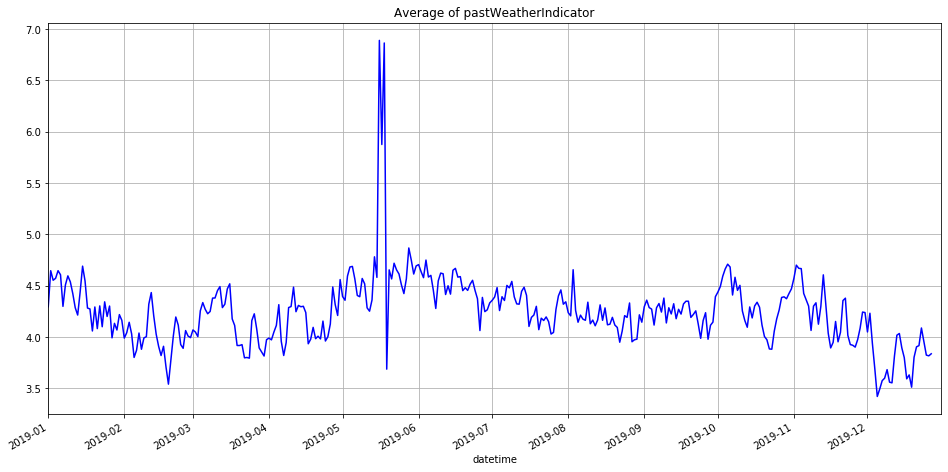

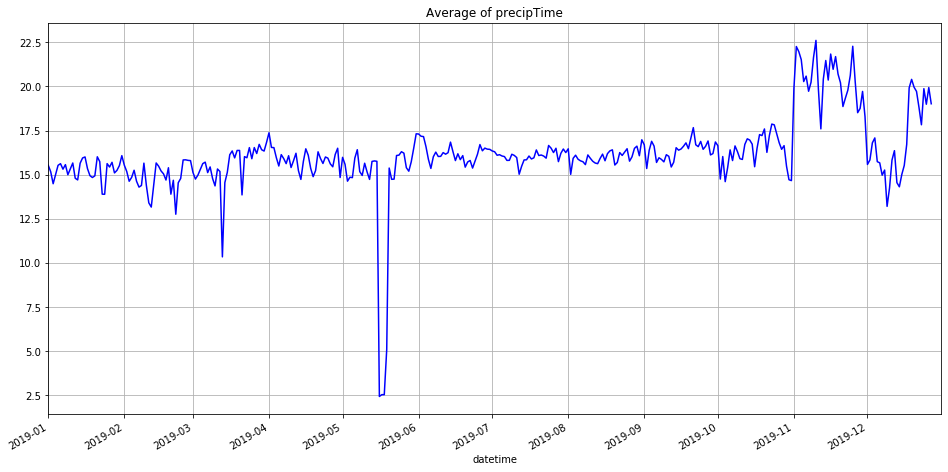

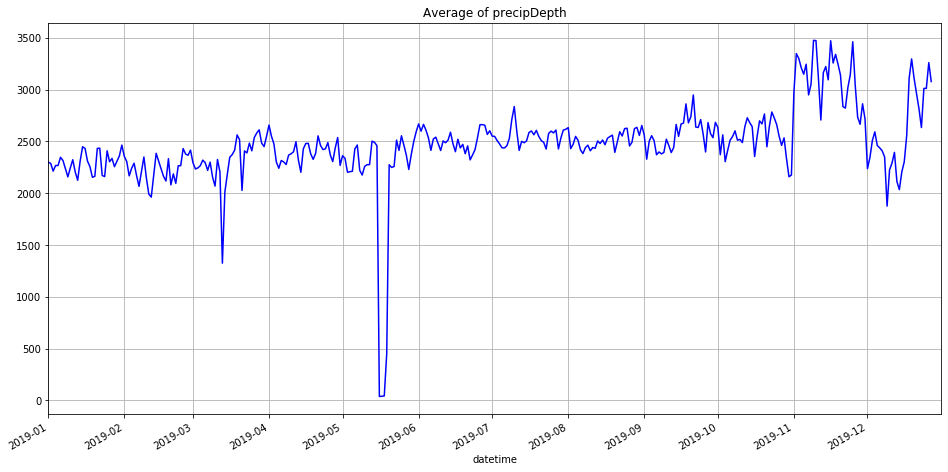

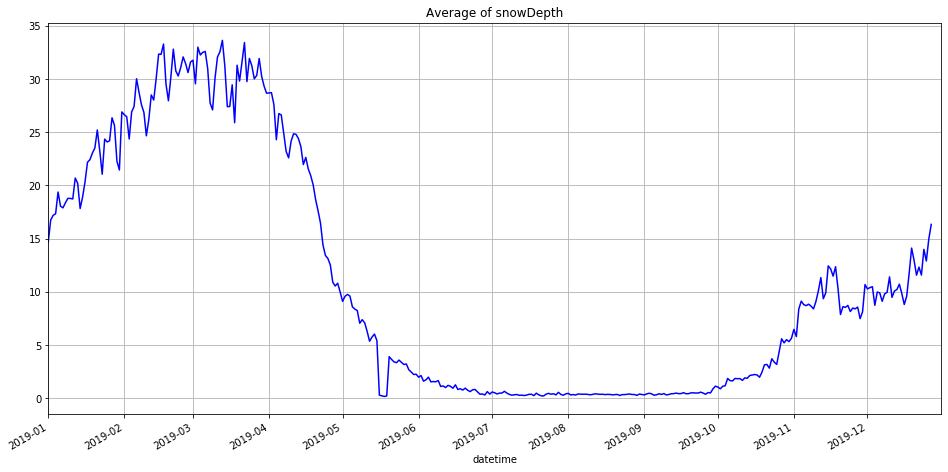

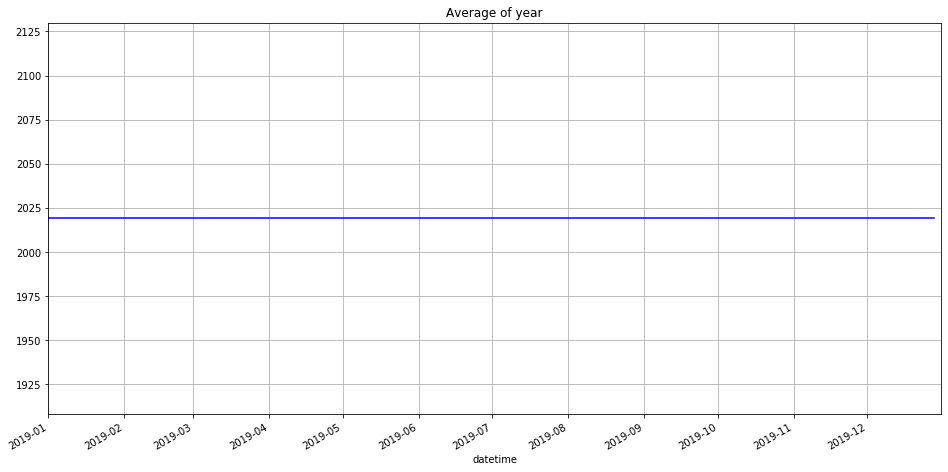

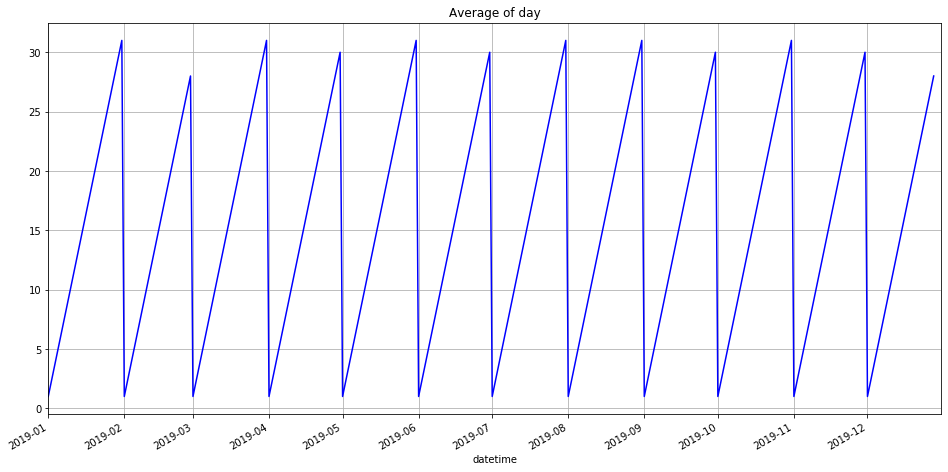

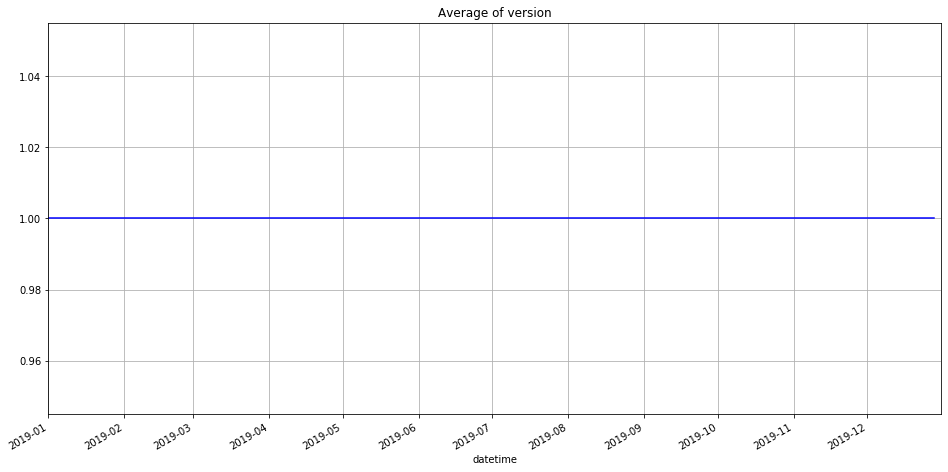

In [20]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, 1, 1), datetime(2019, 12, 31)])
    plt.grid()

In [ ]:
#x = df.groupby(df.index)[['temperature', 'latitude']].corr()

In [22]:
c.close()

## Scale up with Azure ML and Dask

In [23]:
exp_name   = 'dask'
mount      = False
data_path  = '/mnt/noaa'
dset_input = ds.as_named_input('data').as_mount(data_path) if mount else ds.as_named_input('data').as_download(data_path)

script_params = {
    '--datastore': ws.get_default_datastore(),
    #'--script'   : 'run.py' # run code in run.py on cluster and teardown (batch processing)
}

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py', 
                environment_definition  = env, 
                script_params           = script_params,
                inputs                  = [dset_input],
                node_count              = 45,
                distributed_training    = MpiConfiguration()
               )

#run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
run = Experiment(ws, exp_name).submit(est)
run

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


Experiment,Id,Type,Status,Details Page,Docs Page
dask,dask_1577677429_40a4ff83,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [24]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Wait for cluster to setup

Wait for the cluster to spin up, the run to start, and the `start.py` script to complete. At this point, information needed for connecting the cluster will be logged back to the run.

The below cell waits for that information to be logged to the run, sets up port forwarding for the Dask dashboard, and prints the url. Make sure to check out the dashboard as you run through the rest of the notebook.

In [48]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 7070

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    print(f'Setting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

waiting for scheduler node's ip
Setting up port forwarding...
Cluster is ready to use.


## Remote Dask Client setup

In [49]:
c = Client(f'tcp://{run.get_metrics()["scheduler"]}')
c.restart()

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')



<Client: 'tcp://10.1.0.9:8786' processes=45 threads=360, memory=2.66 TB>


In [54]:
files = dask.delayed(glob.glob)(f'{data_path}/year=2008/month=1/*.parquet', recursive=True).compute()
files

['/mnt/noaa/year=2008/month=1/part-00005-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-6.c000.snappy.parquet']

In [61]:
df = dask.delayed(dd.read_parquet)('/mnt/noaa/*/*/*').compute()#[dask.delayed(pd.read_parquet)(file) for file in files])
df.head()

AttributeError: 'DataFrame' object has no attribute 'cat'

In [45]:
%time len(df)

KilledWorker: ("('from-delayed-getitem-read_parquet-len-chunk-0b120ae08ad915c77e58099dc8806576', 0, 11, 0)", <Worker 'tcp://10.1.0.45:33351', name: tcp://10.1.0.45:33351, memory: 0, processing: 1>)

In [46]:
df.head()

KilledWorker: ("('from-delayed-read_parquet-head-1-5-from-delayed-8ca679a3ca92d1f64079bb2784c25470', 0)", <Worker 'tcp://10.1.0.49:34161', name: tcp://10.1.0.49:34161, memory: 0, processing: 1>)

## Run things on the cluster

## Explore the dataset

## Dask dashboard

Copy and paste the url into your browser to view the dask dashboard. 

In [ ]:
c = Client(f'tcp://{run.get_metrics()["scheduler"]}')
c.restart()
print(c)

dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

## Connect to cluster through Dask Client

In [ ]:
import dask
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

c = Client(f'tcp://{run.get_metrics()["scheduler"]}')
c.restart()
c

In [ ]:
import dask
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

c = Client()
c.restart()
c

In [ ]:
import glob

files = dask.delayed(glob.glob)(f'{path}/year=*/*/*.parquet', recursive=True).compute()
len(files)

In [ ]:
#ds.download('/mnt/noaa')

In [ ]:
path = '/mnt/noaa'

## Have fun

**Please read** [this](https://docs.dask.org/en/latest/why.html). Additionally, you can look through the [dask examples](https://github.com/dask/dask-examples) to learn more about dask, especially how to distrubte Python workloads and Pandas operations.

You'll need to connect to the client from any other notebook you run. Or continue below running what I have so far for using the dataset. 

Build the dask array from many Pandas dataframes

In [ ]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])

In [ ]:
df.head()

In [ ]:
%time len(df)

In [ ]:
%time df.describe().compute()

In [ ]:
df.npartitions

Optionally, you could repartition the data like this. See the dask best practices for recommendations around partitioning. 

In [ ]:
#df = df.repartition(npartitions=10*df.npartitions)
#df.npartitions

On a distributed cluster, you can perisist a data in the distributed RAM. Again, see the dask best pratices for recommendations around persisting data

In [ ]:
df.head()

Let's see how long it takes to find the length of the dataset. Without the data persisted, it will take a few tens of seconds

In [ ]:
%time len(df)

## Setup and perisist data for quicker analysis 

Setup the index and persist the dataframe in distributed RAM for quicker processing. Fully expanded, this dataset is ~550 GB. Since we are sorting the data, this will take a long time. This cell can be skipped, but will affect the performance of the later cells. 

In [ ]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist()

Note this will persist the data asynchronously. You can check the dashboard to see the status. The time to find the length of the dataframe will drop to under a second after the data is persisted. This may take a while, check out the graph:

![Index graph](media/index-graph.png)

In [ ]:
%time len(df) # this may be affected by the time the perist call above takes  

In [ ]:
%time len(df) # this will be time after persisting

## Profile the dataset to find useful statistics

In [ ]:
%time df.describe().compute()

## View mean values over time

In [ ]:
%time means = df.groupby(df.index).mean().compute()
means.head()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline 

In [ ]:
fig = plt.figure(figsize=(16, 8))
means['temperature'].plot(color='b')
plt.title('Average of temperature')
plt.xlim([datetime(2008, 1, 1), datetime.now()])
plt.grid()

## Optionally, log the image to the run so it can be viewed or downloaded again later

In [ ]:
# optionally, log the image to the run
run.log_image('avg_temperature', plot=plt)

## Plot average of each (numerical) column

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime.now()])
    plt.grid()
    
    # optionally, log images to the run
    run.log_image(col, plot=plt)

Notice anything? There's clearly something strange going on in 2015 for about a month. There's also suspicious changes in percipitation in a few of the features. Let's dig into the 2015 data for now. 

## Zoom in on 2015

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2015, 1, 1), datetime(2015, 12, 31)])
    plt.grid()

## Compute memory usage of dataframe

In [ ]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

## Prepare data

## Write data

In [ ]:
%time dask.delayed(df.to_parquet)(f'/{run.get_metrics()["datastore"]}/dask/output/noaa', partition_on=['year']).compute()

In [ ]:
df

## Create dataset

In [ ]:
from azureml.core import Dataset

dset = Dataset.File.from_files((ws.get_default_datastore(), '/dask/output/noaa/**/*.parquet'))

In [ ]:
dset = dset.register(ws, 'noaa-dask')
dset

## End the run

Cluster will return to 0 nodes

In [ ]:
run.cancel()

In [ ]:
df = df.drop(['datetime'], axis=1)

In [ ]:
df.index

In [ ]:
def write_data(path):
    df.to_parquet(path)

In [ ]:
a = dask.delayed(write_data)(ds+'/dask/outputs/isd').compute()

In [ ]:
counts = df.groupby([df.index.month, df.index.year]).day.count().compute()

In [ ]:
cs = [counts[month][2015] for month in range(1, 13)]
cs

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2015, 1, 1), datetime(2015, 12, 1)])
    plt.grid()
    
    run.log_image(col, plot=plt)

In [ ]:
df.memory_usage(index=True, deep=True).sum().compute()

In [ ]:
df.info()